## 1. 線形回帰
1つ以上の特徴量と連続値の目的変数との関係をモデルとして表現する。

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt

boston = load_boston()
features = boston.data
target = boston.target
names = boston.feature_names

df = pd.DataFrame(features, columns=names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


#### 単線形回帰(単回帰)
単一の特徴量(説明変数$x$)と連続値の目的変数(応答変数$y$)との関係をモデルとして表現したもの。  
$$
y=w_0+w_1x
$$

ここで、$w_0$はy軸の切片を表し、$w_1$は説明変数の係数を表す。  
線形回帰は「訓練データを通過する直線のうち最も適合するものを見つけ出すこと」と理解できる。   
この最も適合する直線は回帰直線とも呼ばれ、回帰直線から訓練データへの縦線はオフセットまたは残差と呼び、予測値の誤差を表す。  
このモデルの訓練に使われる一般的な性能指標は、二乗平均平方根誤差(RMSE)である。  
線形モデルの訓練では、このRMSEを最小にするパラメータを探す必要がある。  
平均二乗誤差(MSE)は次の式で与えられる。  
$$
MSE=\sum_{i=1}^n\bigl(y^{(i)}-\hat{y}^{(i)}\bigr)^2
$$
RMSEはMSEの平方根を取ったものである。

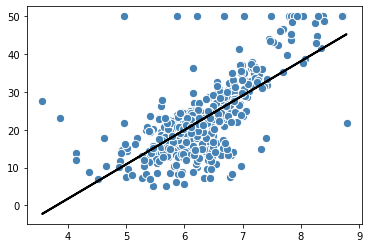

In [2]:
from sklearn.linear_model import LinearRegression

X = df[['RM']]

slr = LinearRegression()
slr.fit(X, target)

y_pred = slr.predict(X)

plt.scatter(X, target, c='steelblue', edgecolor='white', s=70)
plt.plot(X, y_pred, color='black', lw=2)
plt.show()

#### 重線形回帰(重回帰)
線形回帰モデルを複数の説明変数に合わせて一般化したものを、重回帰と呼ぶ。
$$
y=w_0x_0+w_1x_1+\cdots+w_mx_m=\sum_{i=0}^mw_ix_i=\boldsymbol{w}^T\boldsymbol{x}
$$

ここで、$w_0$は$x_0=1$としてy軸の切片を表している。

In [3]:
from sklearn.linear_model import LinearRegression

X = df[['RM', 'CRIM']]

mlr = LinearRegression()
mlr.fit(X, target)

y_pred = mlr.predict(X)

print('Intercept: ', mlr.intercept_)
print('Coef: ', mlr.coef_)

Intercept:  -29.244719451930006
Coef:  [ 8.39106825 -0.26491325]


#### ロバスト回帰モデル
線形回帰モデルは外れ値の存在に大きく左右されることがある。  
外れ値の除去に代わる方法として、**RANSAC(RANdom SAmple Consensus)**アルゴリズムを使ったロバスト回帰がある。  
回帰モデルに正常値(外れ値ではないもの)を学習させる。  
1. 正常値としてランダムな数のデータ点を選択し、モデルを学習させる
2. 学習済みのモデルに対して、その他すべてのデータ点を評価し、許容範囲となるデータ点を正常値に追加する
3. すべての正常値を使ってモデルを再び学習させる
4. 正常値に対する学習済みのモデルの誤差を推定する
5. モデルの性能が閾値の条件を満たしている場合、またはイテレーションが既定の回数に達した場合はアルゴリズムを終了する。  
そうでなければ手順1に戻る

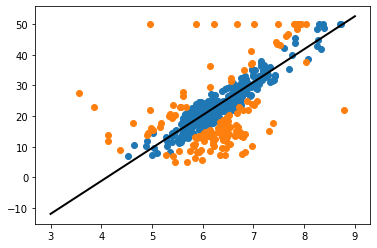

In [4]:
from sklearn.linear_model import RANSACRegressor
import numpy as np

X = df[['RM']]

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, target)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], target[inlier_mask])
plt.scatter(X[outlier_mask], target[outlier_mask])
plt.plot(line_X, line_y_ransac, color='black', lw=2)

#### 正則化
正則化は過学習の問題に対処する手法の1つであり、モデルの極端なパラメータの重みにペナルティを科す。  
正則化された線形回帰の一般的なアプローチは、
- リッジ回帰
- LASSO
- Elastic Net

の3つである。　　

#### リッジ回帰
リッジ回帰では、最小二乗コスト関数に対してL2ペナルティを足し合わせる。
$$
J(\boldsymbol{w})_{Ridge}=\sum_{i=1}^n\bigl(y^{(i)}-\hat{y}^{(i)}\bigr)^2+\lambda |\boldsymbol{w}|_2^2
$$
ここで、L2ペナルティを次のように定義する。
$$
\lambda |\boldsymbol{w}|_2^2=\lambda\sum_{j=1}^mw_j^2
$$

また、$\lambda$は正則化の強さを表すパラメータであり、この値が大きいと係数はより0に近くなる。

In [5]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(df)
y_std = sc_y.fit_transform(target.reshape(-1,1))


ridge001 = Ridge(alpha=0.01)
ridge1 = Ridge(alpha=1.0)
ridge100 = Ridge(alpha=100.0)

ridge001.fit(X_std, target)
ridge1.fit(X_std, target)
ridge100.fit(X_std, target)

Ridge(alpha=100.0)

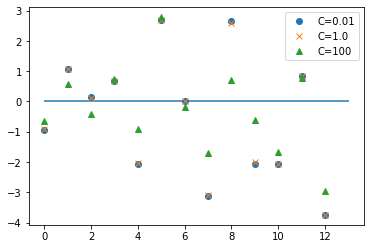

In [7]:
plt.hlines(0, 0, len(ridge001.coef_));
plt.plot(ridge001.coef_, 'o', label='C=0.01');
plt.plot(ridge1.coef_, 'x', label='C=1.0');
plt.plot(ridge100.coef_, '^', label='C=100');
plt.legend();

#### LASSO回帰
LASSO回帰では、最小二乗コスト関数に対してL1ペナルティを足し合わせる。
$$
J(\boldsymbol{w})_{Ridge}=\sum_{i=1}^n\bigl(y^{(i)}-\hat{y}^{(i)}\bigr)^2+\lambda |\boldsymbol{w}|_1
$$
ここで、L2ペナルティを次のように定義する。
$$
\lambda |\boldsymbol{w}|_1=\lambda\sum_{j=1}^m|w_j|
$$

また、$\lambda$は正則化の強さを表すパラメータであり、この値が大きいと0になる係数の数が増える。

In [8]:
from sklearn.linear_model import Lasso

lasso01 = Lasso(alpha=0.1)
lasso1 = Lasso(alpha=1.0)
lasso10 = Lasso(alpha=10.0)

lasso01.fit(X_std, target)
lasso1.fit(X_std, target)
lasso10.fit(X_std, target)

Lasso(alpha=10.0)

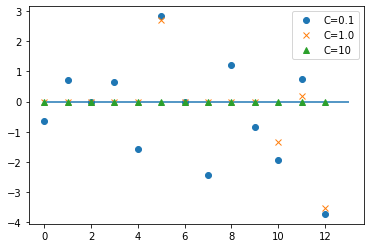

In [11]:
plt.hlines(0, 0, len(lasso01.coef_));
plt.plot(lasso01.coef_, 'o', label='C=0.1');
plt.plot(lasso1.coef_, 'x', label='C=1.0');
plt.plot(lasso10.coef_, '^', label='C=10');
plt.legend();

In [12]:
from sklearn.linear_model import ElasticNet

elanet01 = ElasticNet(alpha=0.1, l1_ratio=0.5)
elanet1 = ElasticNet(alpha=1.0, l1_ratio=0.5)
elanet10 = ElasticNet(alpha=10.0, l1_ratio=0.5)

elanet01.fit(X_std, target)
elanet1.fit(X_std, target)
elanet10.fit(X_std, target)

ElasticNet(alpha=10.0)

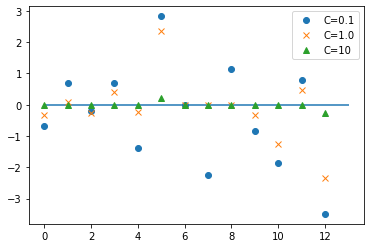

In [14]:
plt.hlines(0, 0, len(lasso01.coef_));
plt.plot(elanet01.coef_, 'o', label='C=0.1');
plt.plot(elanet1.coef_, 'x', label='C=1.0');
plt.plot(elanet10.coef_, '^', label='C=10');
plt.legend();

#### 交互作用と多項式
ある特徴量のターゲット変数への影響が、他の特徴量に依存している場合、特徴量に**交互作用項**を追加する。  
また、非線形な関係をモデル化するために多項式の項を追加する。  
$$
y=w_0+w_1x+w_2x^2+\cdots+w_dx^d+w_{12}x_1x_2+w_{13}x_1x_3+\cdots+w_{d-1,d}x_{d-1}x_{d}
$$

ここで、係数$w$については線形であるため、重回帰モデルと見なされる。

In [15]:
from sklearn.preprocessing import PolynomialFeatures

X3 = X_std[:,:3]

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X3)
print(X_std.shape)
print(X_poly.shape)
print(np.array(poly.get_feature_names()))

rl = LinearRegression()
rl.fit(X_poly, target)

(506, 13)
(506, 6)
['x0' 'x1' 'x2' 'x0 x1' 'x0 x2' 'x1 x2']


LinearRegression()

In [16]:
from sklearn.preprocessing import PolynomialFeatures

X = df[['LSTAT']].values
y = target.reshape(-1,1)

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

lr = LinearRegression()

lr.fit(X, y)
y_lin_fit = lr.predict(X_fit)

lr.fit(X_quad, y)
y_quad_fit = lr.predict(quadratic.fit_transform(X_fit))

lr.fit(X_cubic, y)
y_cubic_fit = lr.predict(cubic.fit_transform(X_fit))

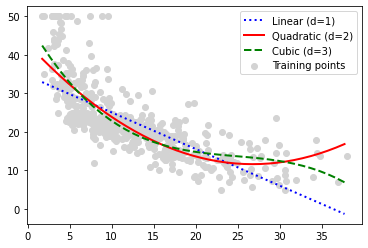

In [17]:
plt.scatter(X, y, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='Linear (d=1)', color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='Quadratic (d=2)', color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='Cubic (d=3)', color='green', lw=2, linestyle='--')
plt.legend();

#### PLS(Partial Least Squares: 部分的最小二乗回帰)  
目的変数と説明変数の共分散が最大になるように新しい軸をとる

In [49]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression()
pls.fit(features, target)

PLSRegression()

In [45]:
print(f"coefficient: {pls.coef_}")

coefficient: [[-3.02841751]
 [ 2.70794884]]


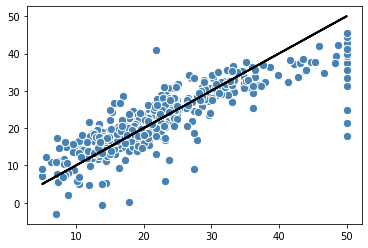

In [50]:
y_pred = pls.predict(features)

plt.scatter(target, y_pred, c='steelblue', edgecolor='white', s=70)
plt.plot(target, target, color='black', lw=2)
plt.show()